In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx
import imageio
import os
from scipy import linalg
from scipy import sparse
import pywt
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import imageio
from skimage.metrics import peak_signal_noise_ratio
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"  # specify which GPU(s) to be used
import brainpy as bp
import brainpy.math as bm
bm.disable_gpu_memory_preallocation()
bm.set_platform('gpu')

/home/spirit/anaconda3/envs/cy_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def imshowgray(im, vmin=None, vmax=None):
    plt.imshow(im, cmap=plt.get_cmap('gray'), vmin=vmin, vmax=vmax)

    
def wavMask(dims, scale):
    sx, sy = dims
    res = np.ones(dims)
    NM = np.round(np.log2(dims))
    for n in range(int(np.min(NM)-scale+2)//2):
        res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))] = \
            res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))]/2
    return res


def imshowWAV(Wim, scale=1):
    plt.imshow(np.abs(Wim)*wavMask(Wim.shape, scale), cmap = plt.get_cmap('gray'))

    
def coeffs2img(LL, coeffs):
    LH, HL, HH = coeffs
    return np.vstack((np.hstack((LL, LH)), np.hstack((HL, HH))))


def unstack_coeffs(Wim):
        L1, L2  = np.hsplit(Wim, 2) 
        LL, HL = np.vsplit(L1, 2)
        LH, HH = np.vsplit(L2, 2)
        return LL, [LH, HL, HH]

    
def img2coeffs(Wim, levels=4):
    LL, c = unstack_coeffs(Wim)
    coeffs = [c]
    for i in range(levels-1):
        LL, c = unstack_coeffs(LL)
        coeffs.insert(0,c)
    coeffs.insert(0, LL)
    return coeffs
    
    
def dwt2(im):
    coeffs = pywt.wavedec2(im, wavelet='db4', mode='per', level=4)
    Wim, rest = coeffs[0], coeffs[1:]
    for levels in rest:
        Wim = coeffs2img(Wim, levels)
    return Wim


def idwt2(Wim):
    coeffs = img2coeffs(Wim, levels=4)
    return pywt.waverec2(coeffs, wavelet='db4', mode='per')

In [3]:
im  = imageio.imread('brain.bmp', mode='F')

Wim = dwt2(im)
f = 0.1
m = np.sort(abs(Wim.ravel()))[::-1]
ndx = int(len(m) * f)
thr = m[ndx]
Wim_thr = Wim * (abs(Wim) > thr)

im3 = idwt2(Wim_thr)
Wim_plus  = np.maximum(Wim_thr,0)
Wim_minus = np.minimum(Wim_thr,0)

scale_factor =  abs(np.min(Wim_minus))

X_plus_normalized  = Wim_plus/np.max(Wim_plus)
X_minus_normalized = Wim_minus/np.min(Wim_minus)

/tmp/ipykernel_4173425/2433121348.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im  = imageio.imread('brain.bmp', mode='F')


In [4]:
W_plus  = np.load('W_plus.npy')
W_minus = np.load('W_minus.npy')
Wim_recov = Wim_plus - W_minus
im_recov = idwt2(Wim_recov)

PSNR: 34.61616958033244


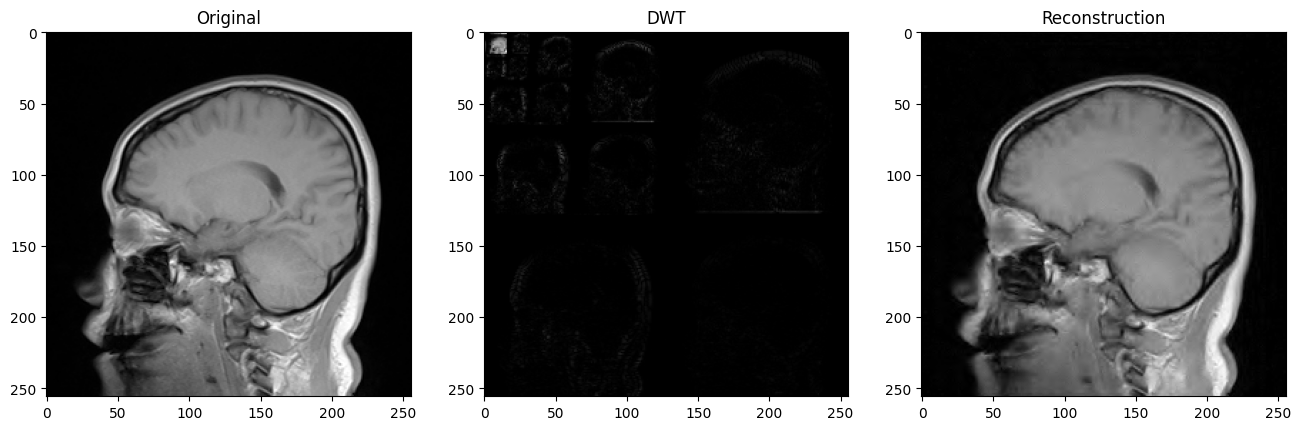

In [5]:
plt.rcParams['figure.figsize'] = (16, 16)
plt.subplot(1,3,1)
imshowgray(np.abs(im))
plt.title('Original')

plt.subplot(1,3,2)
imshowWAV(Wim)
plt.title('DWT')

plt.subplot(1,3,3)
imshowgray(np.abs(im_recov))
plt.title('Reconstruction')

print('PSNR:', peak_signal_noise_ratio(im, im_recov, data_range=im.max() - im.min()))

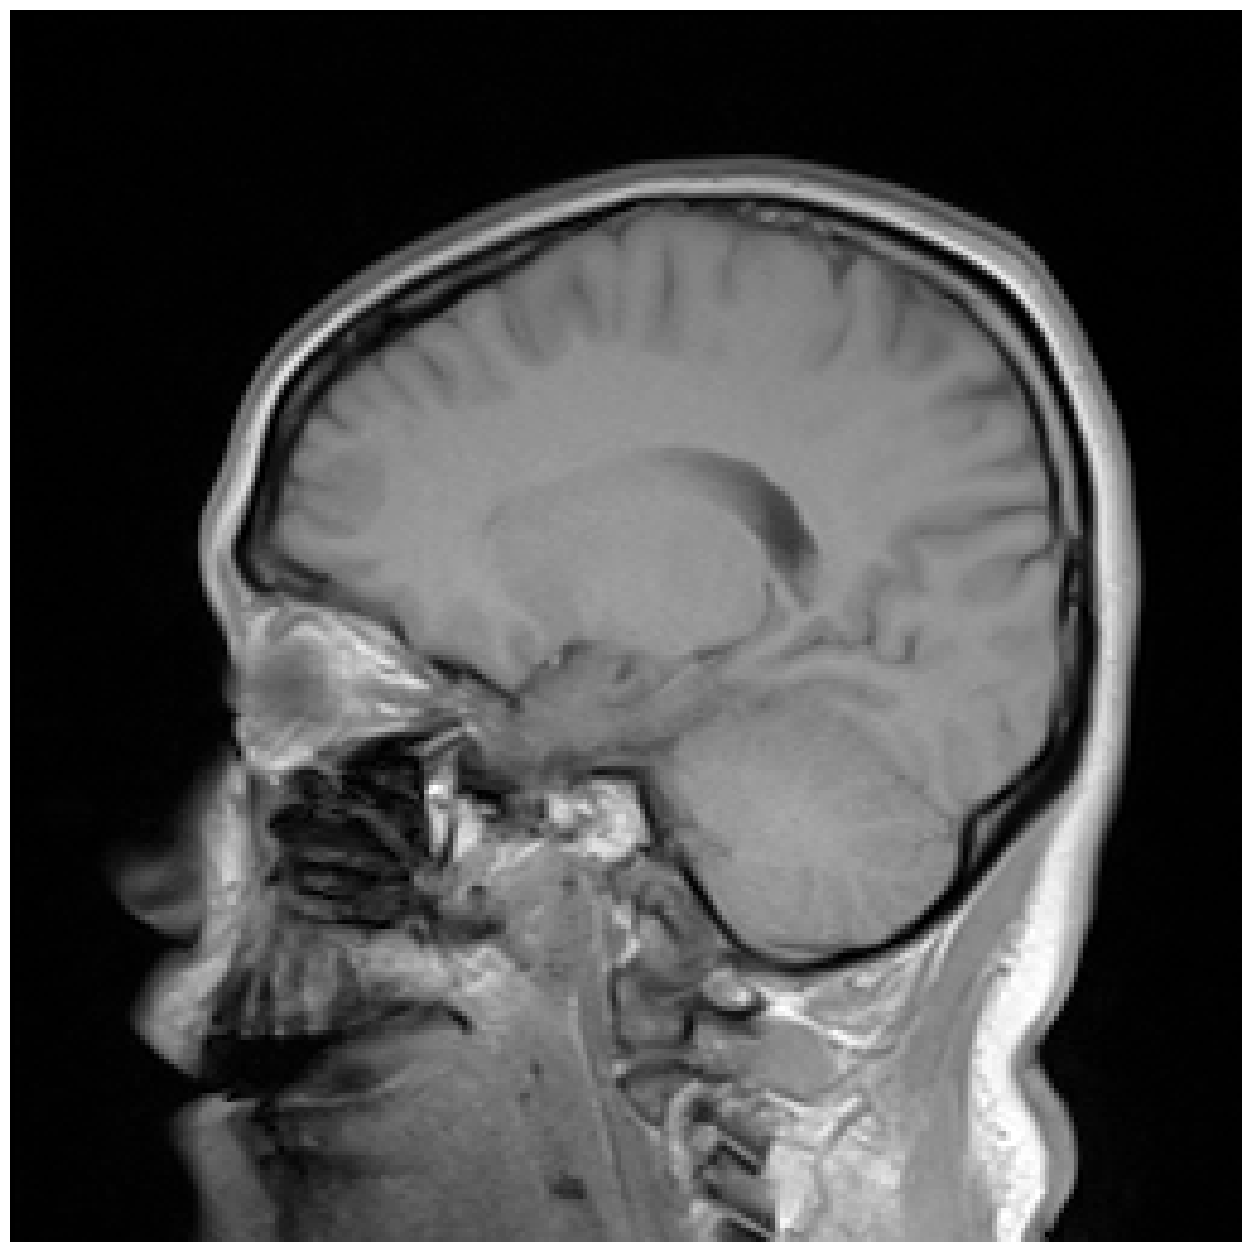

In [14]:
imshowgray(np.abs(im))
plt.axis('off')
plt.savefig('CT_Original.pdf')

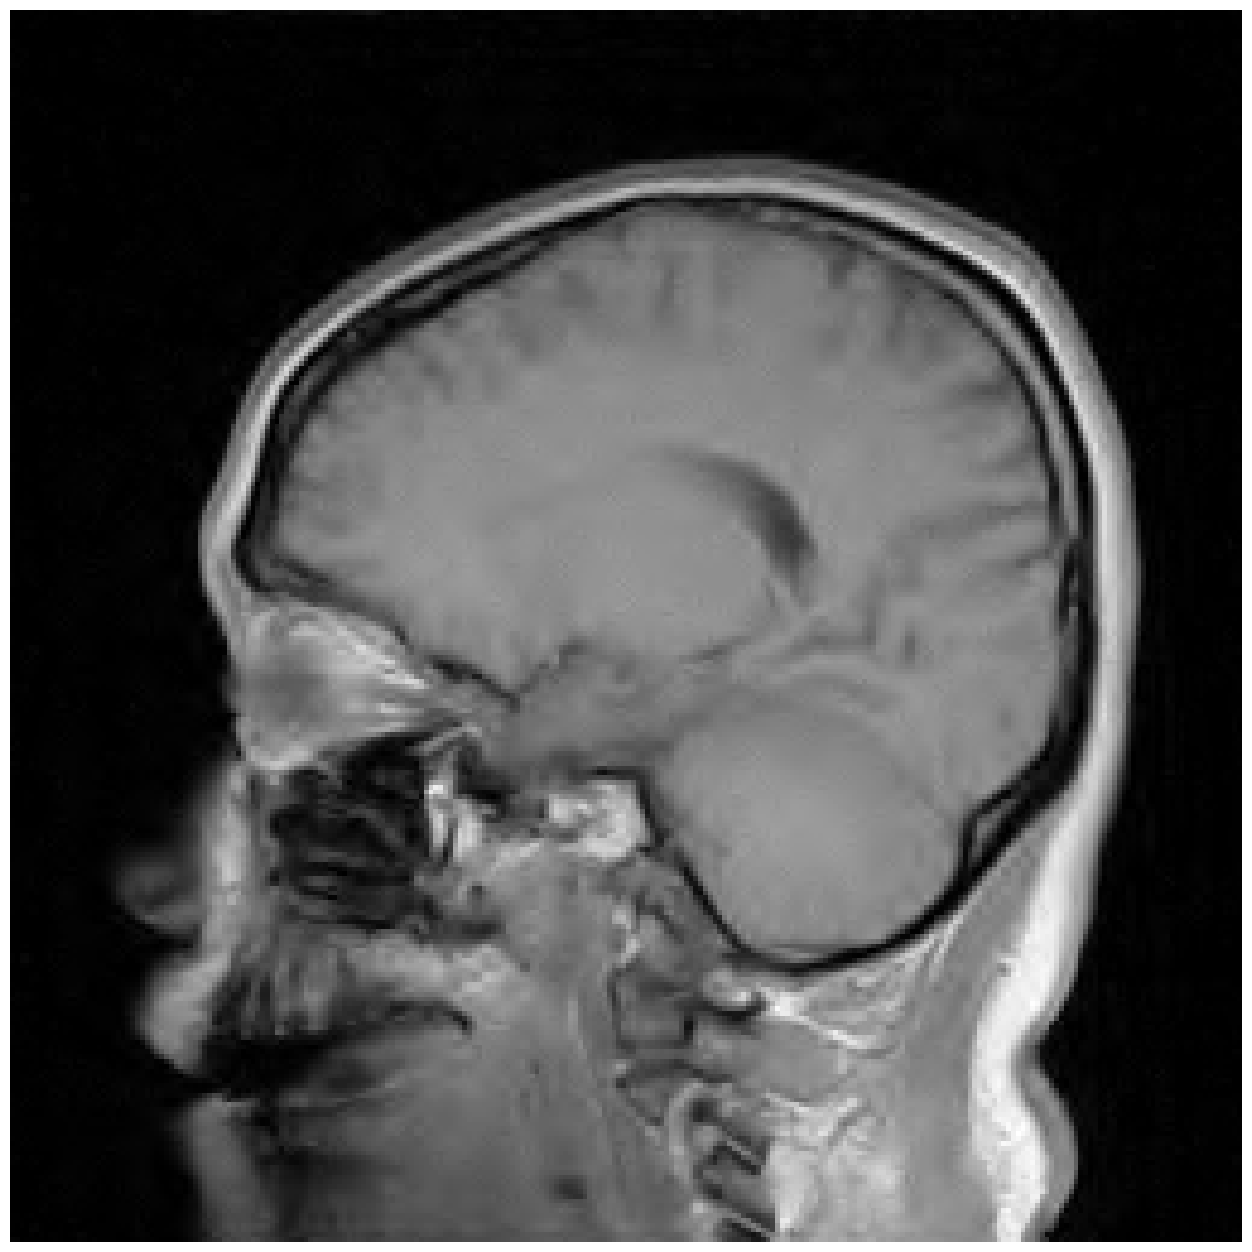

In [13]:
imshowgray(np.abs(im_recov))
plt.axis('off')
plt.savefig('CT_reconstruction.pdf')

In [15]:
file_path   = "/data/spirit/"
image_fista = np.load(file_path +'image_fista.npy')

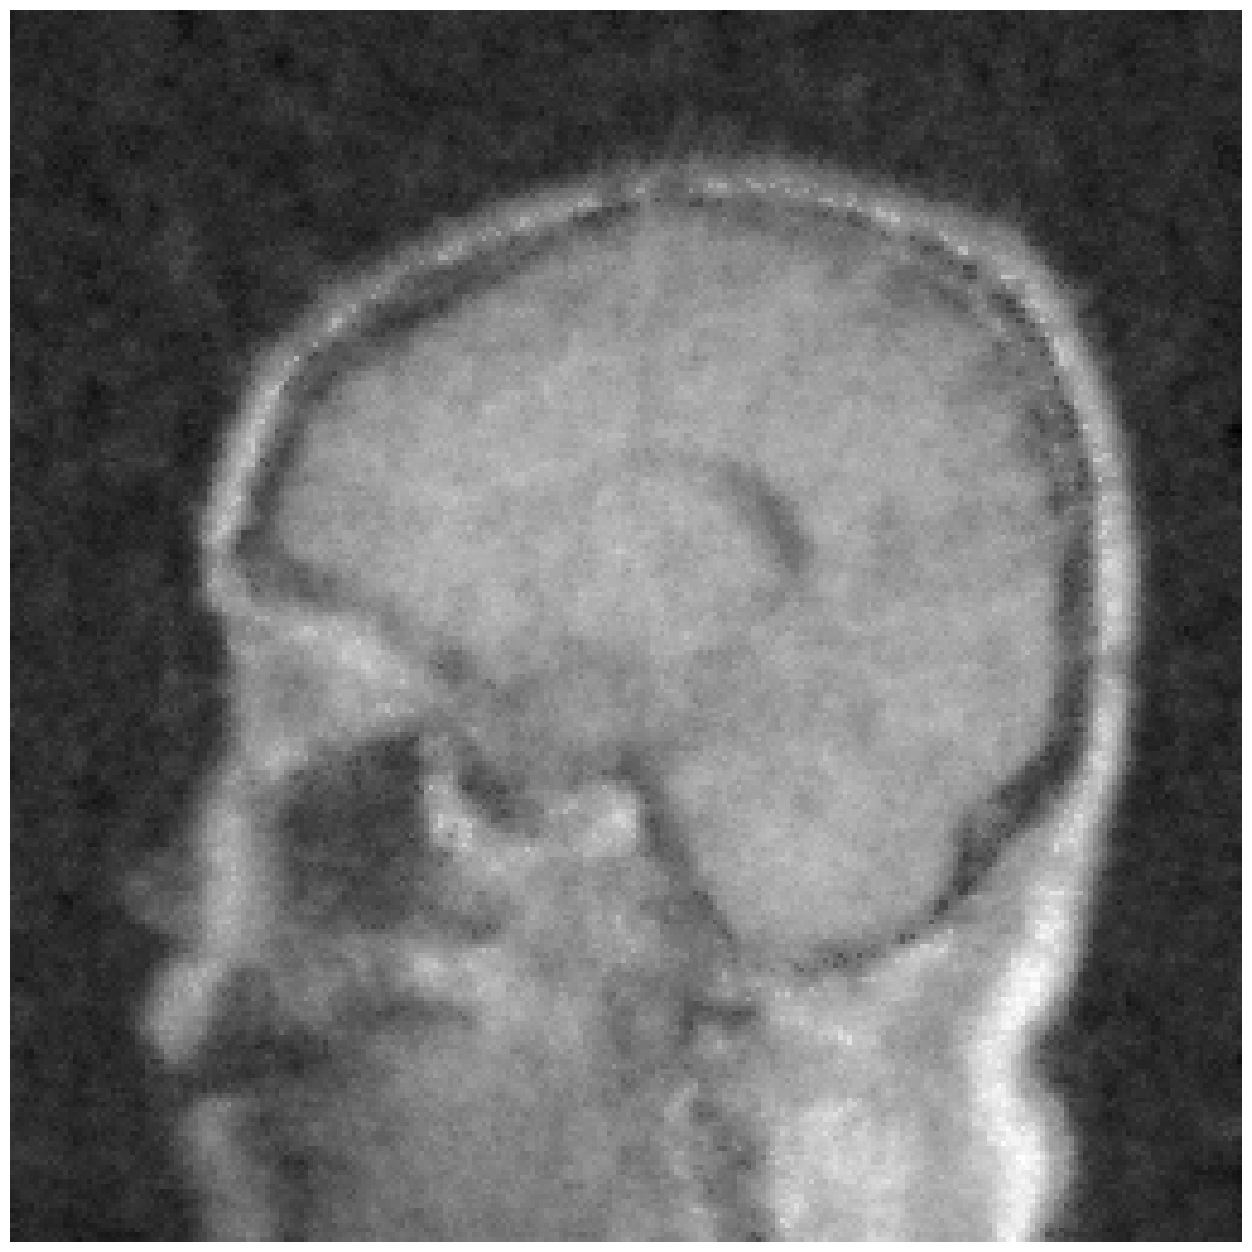

In [16]:
imshowgray(image_fista)
plt.axis('off')
plt.savefig('CT_fista.pdf')

In [17]:
peak_signal_noise_ratio(im, image_fista, data_range=im.max() - im.min())

22.927541856337086